Dataset shape: (5572, 2)

Label distribution:
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

Sample messages:


,label,message
3245,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
944,ham,And also I've sorta blown him off a couple tim...
1044,ham,Mmm thats better now i got a roast down me! i...
2484,ham,Mm have some kanji dont eat anything heavy ok
812,ham,So there's a ring that comes with the guys cos...


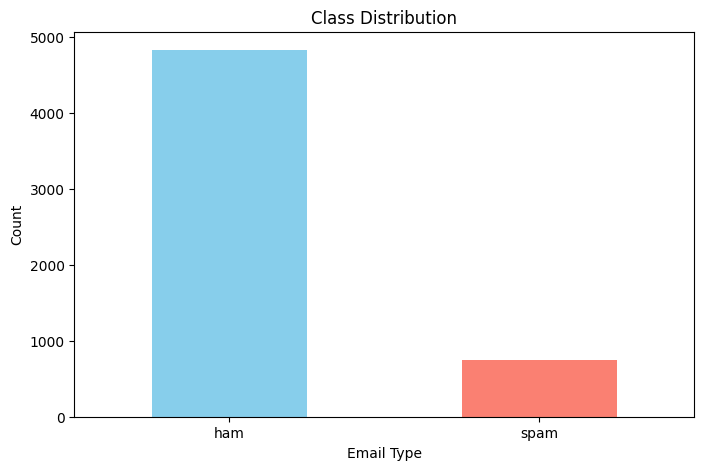


Original vs Cleaned Text:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned: go jurong point crazi avail bugi n great world la e buffet cine got amor wat

Original: Ok lar... Joking wif u oni...
Cleaned: ok lar joke wif u oni

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Cleaned: free entri wkli comp win fa cup final tkt st may text fa receiv entri questionstd txt ratetc appli over

Top 20 features:
- abiola
- abl
- abt
- access
- account
- account statement
- across
- across sea
- act
- activ
- actual
- ad
- add
- address
- admir
- admir look
- adult
- advic
- affair
- aft

Naive Bayes Performance:
Accuracy: 0.9767
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.99      0.83      0.

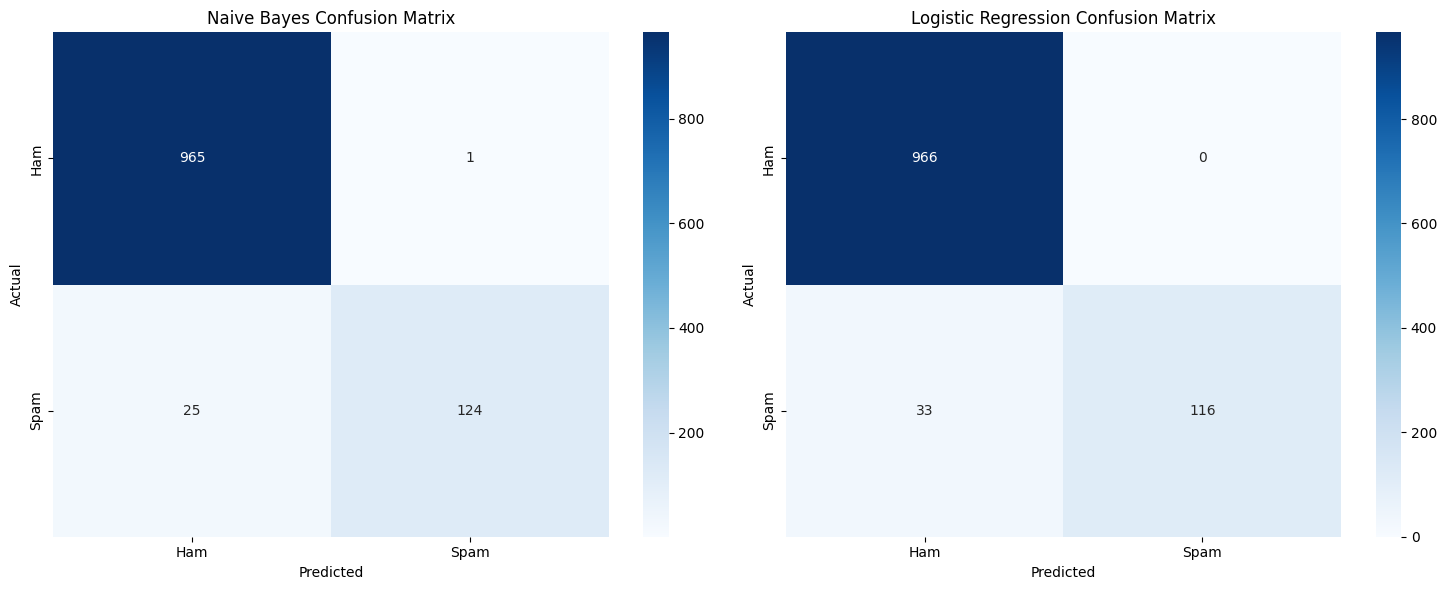

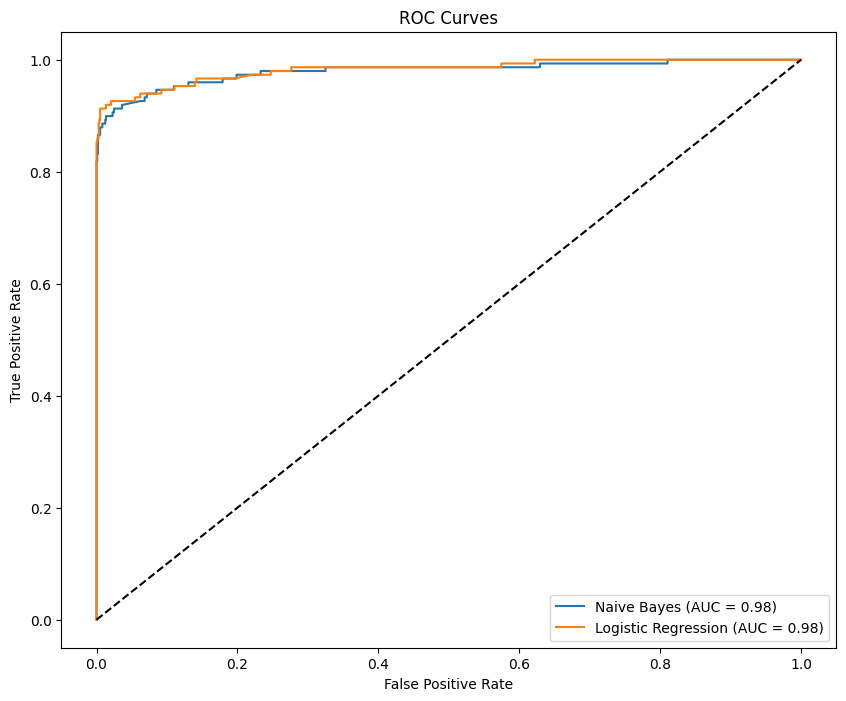

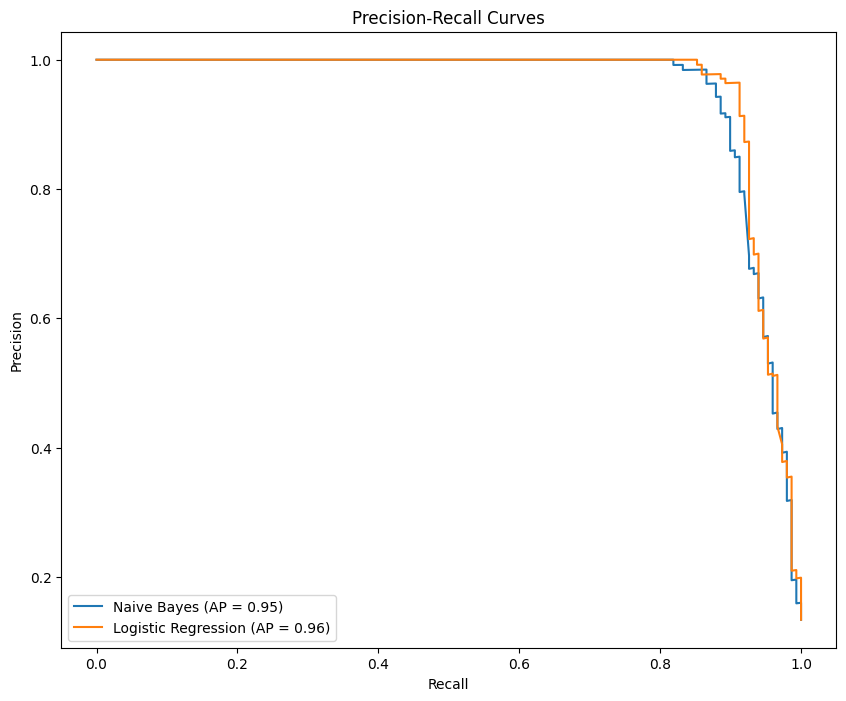


Predictions:

Message: 'Congratulations! You've won a $1000 gift card. Claim now!'
Prediction: Ham (0.3555 probability)

Message: 'Meeting reminder: Tomorrow at 3 PM in conference room'
Prediction: Ham (0.0490 probability)

Message: 'URGENT: Your account needs verification. Click here to secure: http://fake.link'
Prediction: Ham (0.2212 probability)

Message: 'Hey, are we still on for dinner tonight?'
Prediction: Ham (0.0186 probability)

Message: 'Free entry in 2 a weekly comp to win FA Cup final tkts 21st May'
Prediction: Ham (0.4634 probability)


In [2]:

# # Spam Email Detection with Machine Learning
# This notebook demonstrates building a predictive model to classify emails as spam or ham (non-spam) using scikit-learn.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string

# Download NLTK resources
nltk.download('stopwords', quiet=True)

# Set random seed for reproducibility
np.random.seed(42)

# %% [markdown]
# ## 1. Data Loading and Exploration
# We'll use the SMS Spam Collection Dataset from UCI

# %%
# Load dataset
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Display dataset info
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts(normalize=True))
print("\nSample messages:")
display(df.sample(5))

# Visualize class distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# %% [markdown]
# ## 2. Data Preprocessing
# Clean and prepare text data for modeling

# %%
def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Apply stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

# Apply preprocessing
df['clean_text'] = df['message'].apply(preprocess_text)

# Display preprocessing results
print("\nOriginal vs Cleaned Text:")
for i in range(3):
    print(f"\nOriginal: {df['message'].iloc[i]}")
    print(f"Cleaned: {df['clean_text'].iloc[i]}")

# Encode labels (spam=1, ham=0)
df['label_encoded'] = df['label'].map({'spam': 1, 'ham': 0})

# %% [markdown]
# ## 3. Feature Engineering
# Create TF-IDF features from text

# %%
# Split data
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

# Transform text data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Feature analysis
feature_names = tfidf.get_feature_names_out()
print(f"\nTop 20 features:")
for feature in feature_names[:20]:
    print(f"- {feature}")

# %% [markdown]
# ## 4. Model Building
# Train and evaluate classifiers

# %%
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    y_proba = model.predict_proba(X_test_tfidf)[:, 1]
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'y_proba': y_proba
    }
    
    # Print results
    print(f"\n{name} Performance:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("Classification Report:")
    print(results[name]['classification_report'])

# %% [markdown]
# ## 5. Model Evaluation
# Compare model performance

# %%
# Confusion matrices
plt.figure(figsize=(15, 6))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(1, 2, i)
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC curves
plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res['y_proba'])
    avg_precision = average_precision_score(y_test, res['y_proba'])
    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

# %% [markdown]
# ## 6. Prediction Demonstration
# Test the model with custom examples

# %%
def predict_spam(model, text):
    """Predict whether a message is spam"""
    cleaned_text = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned_text])
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0][1]
    return "Spam" if prediction == 1 else "Ham", probability

# Select best model
best_model = results['Logistic Regression']['model']

# Test examples
test_messages = [
    "Congratulations! You've won a $1000 gift card. Claim now!",
    "Meeting reminder: Tomorrow at 3 PM in conference room",
    "URGENT: Your account needs verification. Click here to secure: http://fake.link",
    "Hey, are we still on for dinner tonight?",
    "Free entry in 2 a weekly comp to win FA Cup final tkts 21st May"
]

print("\nPredictions:")
for msg in test_messages:
    pred, prob = predict_spam(best_model, msg)
    print(f"\nMessage: '{msg}'")
    print(f"Prediction: {pred} ({prob:.4f} probability)")